In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [3]:
shps_f_list = glob.glob('./ground_data/historical/pDog_*.shp')
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [4]:
cper = gpd.read_file(cper_f)

<AxesSubplot:>

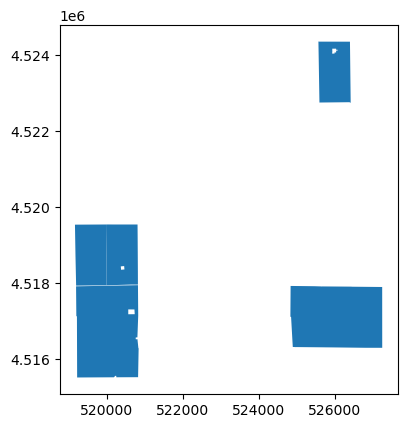

In [5]:
cper.plot()

In [6]:
cell_size = 5.0
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry, cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)

In [7]:
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))

In [8]:
cper_xr = cper_xr.where(cper_xr != 0)

In [9]:
shps_f_list

['./ground_data/historical/pDog_2011.shp',
 './ground_data/historical/pDog_2012.shp',
 './ground_data/historical/pDog_2013.shp',
 './ground_data/historical/pDog_2014.shp',
 './ground_data/historical/pDog_2015.shp',
 './ground_data/historical/pDog_2016.shp',
 './ground_data/historical/pDog_2017.shp',
 './ground_data/historical/pDog_2018.shp',
 './ground_data/historical/pDog_2019.shp',
 './ground_data/historical/pDog_2020.shp',
 './ground_data/historical/pDog_2021.shp']

In [10]:
shps_f_list = shps_f_list[:-1]
shps_f_list.append(
    './ground_data/PdogMapping_July2021/PolygonsForCPER_PawneeJuly2021/All_CPER_Pawnee_July2021.shp')

In [11]:
shps_f_list

['./ground_data/historical/pDog_2011.shp',
 './ground_data/historical/pDog_2012.shp',
 './ground_data/historical/pDog_2013.shp',
 './ground_data/historical/pDog_2014.shp',
 './ground_data/historical/pDog_2015.shp',
 './ground_data/historical/pDog_2016.shp',
 './ground_data/historical/pDog_2017.shp',
 './ground_data/historical/pDog_2018.shp',
 './ground_data/historical/pDog_2019.shp',
 './ground_data/historical/pDog_2020.shp',
 './ground_data/PdogMapping_July2021/PolygonsForCPER_PawneeJuly2021/All_CPER_Pawnee_July2021.shp']

In [34]:
from tqdm import tqdm
yr_xr_list = []
yr_list = []

for f in tqdm(shps_f_list):
    gdf_yr = gpd.read_file(f)
    gdf_yr = gdf_yr.to_crs(32613)
    yr_xr = shp2mask(gdf_yr.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape)
    yr_xr_list.append(yr_xr)
    yr_list.append(int(re.sub('July', '', re.sub('.shp', '', f.split('_')[-1]))))

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.36it/s]


In [35]:
da_all_yrs = xr.concat(yr_xr_list, pd.Index(yr_list, name='Year'))

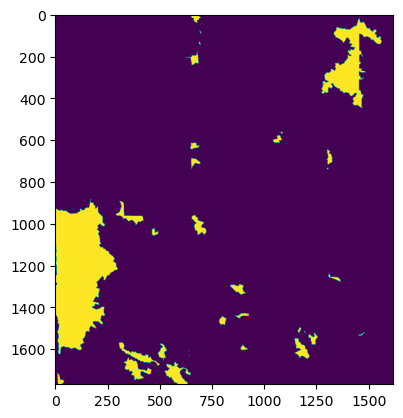

<AxesSubplot:>

In [36]:
from rasterio.plot import show
show(da_all_yrs.sel(Year=2021).data)

In [37]:
da_active = ((da_all_yrs.sel(Year=2021) == 1) & 
             (da_all_yrs.sel(Year=2020) == 0)).astype('int')
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                         (da_all_yrs.sel(Year=2020) == 1) & 
                         (da_all_yrs.sel(Year=2019) == 0)).astype('int') * 2
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                         (da_all_yrs.sel(Year=2020) == 1) & 
                         (da_all_yrs.sel(Year=2019) == 1) & 
                         (da_all_yrs.sel(Year=2018) == 0)).astype('int') * 3
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                         (da_all_yrs.sel(Year=2020) == 1) & 
                         (da_all_yrs.sel(Year=2019) == 1) & 
                         (da_all_yrs.sel(Year=2018) == 1) & 
                         (da_all_yrs.sel(Year=2017) == 0)).astype('int') * 4
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) &
                         (da_all_yrs.sel(Year=2020) == 1) & 
                         (da_all_yrs.sel(Year=2019) == 1) & 
                         (da_all_yrs.sel(Year=2018) == 1) &
                         (da_all_yrs.sel(Year=2017) == 1) & 
                         (da_all_yrs.sel(Year=2016) == 0)).astype('int') * 5
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) &
                            (da_active == 0)) * 6

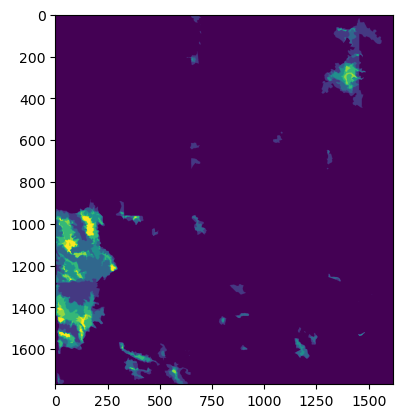

<AxesSubplot:>

In [38]:
show(da_active.data)

In [39]:
da_old = (da_all_yrs.sel(Year=2021) == 0) * 6.0
da_old = da_old - ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 1)) * 5.0
da_old = da_old -  ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 0) &
                   (da_all_yrs.sel(Year=2019) == 1)) * 4.0
da_old = da_old - ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 0) &
                   (da_all_yrs.sel(Year=2019) == 0) &
                   (da_all_yrs.sel(Year=2018) == 1)) * 3.0
da_old = da_old - ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 0) &
                   (da_all_yrs.sel(Year=2019) == 0) &
                   (da_all_yrs.sel(Year=2018) == 0) &
                   (da_all_yrs.sel(Year=2017) == 1)) * 2.0
da_old = da_old.where(da_all_yrs.sel(Year=2021) == 0)

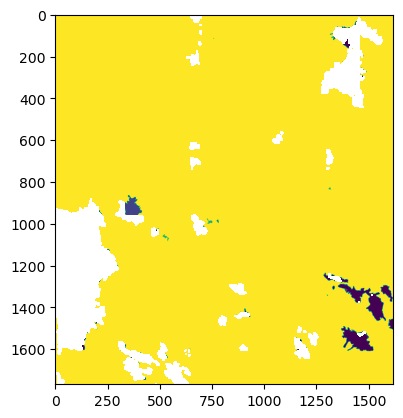

<AxesSubplot:>

In [40]:
show(da_old.data)

In [41]:
da_active.where(cper_xr.notnull()).rio.to_raster('./ground_data/PdogMapping_July2021/July2021_active_yrs.tif')
da_old.where(cper_xr.notnull()).rio.to_raster('./ground_data/PdogMapping_July2021/July2021_old_yrs.tif')

In [42]:
da_old_any = ((da_all_yrs.sel(Year=2021) == 0) & 
                   ((da_all_yrs.sel(Year=2020) == 1) |
                   (da_all_yrs.sel(Year=2019) == 1) |
                   (da_all_yrs.sel(Year=2018) == 1) |
                   (da_all_yrs.sel(Year=2017) == 1)))

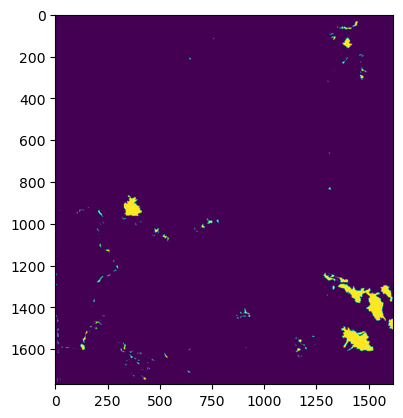

<AxesSubplot:>

In [43]:
show(da_old_any.data)

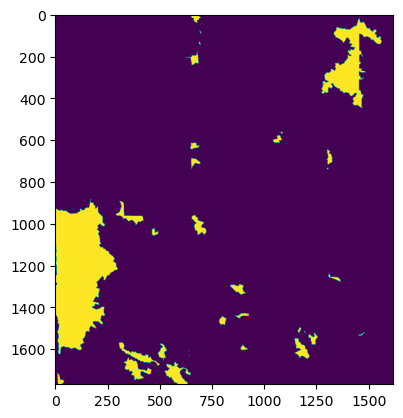

<AxesSubplot:>

In [44]:
show(da_all_yrs.sel(Year=2021).data)

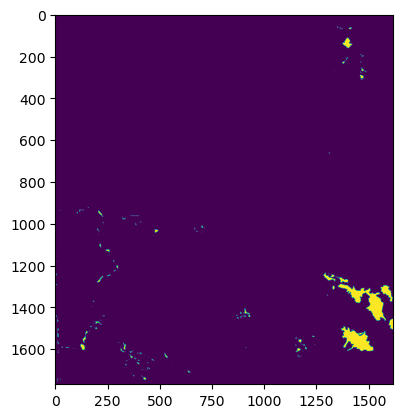

<AxesSubplot:>

In [45]:
show(((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 1)).data)